
### Choose appropriate X and A  use dynamic programming (programmed in 
python) to determine the total expected profit and the optimal order policy, 
starting with 0 inventory at time 0

- X(state) is  the current number of items in inventory max value of which can be
     x_max(currently 10 is used for simplicity of understanding) - current level + demand
- A(action) is placing an order 

## Simulation with lost sales and 10 times

In [2]:
import numpy as np
import pandas as pd
import random
import seaborn as sns


In [19]:
# Number of simulations 
MAX_SIM = 10

# To store the max profit of each simulation
max_profits_list = []

# To store the inventory level fo each simulation
inventory_lvl_df = None

# To store the lost sale of each simulation
lost_sale_df = None

results = []

inventory_lvl_list = []
lost_sale_list = []


for sim in range(1, MAX_SIM+1):

    T = 1000
    x_max = 500
    # holding cost
    h = 0.01
    # purchase cost
    c = 10
    # selling price
    p = 20
    # order cost
    K = 10
    # stores inventory lvl at each time period
    inventory_lvl_dict = {}
    inventory = 0

    #stores demand at each time period
    demand_dict = {}
    lost_sale_dict = {}
    lost_sale = 0

    V = np.array([[float(0) for i in range(T)] for j in range(x_max + 2)])
    alpha = np.array([[float(0)for i in range(T)] for j in range(x_max + 2)])

    # initialized the last column: hx
    V[:, -1] = [x * h for x in range(0, x_max + 2)] 


    for t in range(T - 2, -1, -1):
        c = 10 if t <= 500 else 15

        # P(D=1) distribution
        dIsOne = t / 1000
        dIsZero = 1 - dIsOne
        # d is assigned to 1 or 0 based on the weights of dIsOne and dIsZero
        d = random.choices([1, 0], weights=(dIsOne, dIsZero), k = 1)[0]
        
        # recording the demand at every time period
        demand_dict[t] = d
        
        if t > 900:
            # At t > 900 no order can be placed, so a = 0
            for x in range(0, x_max + 1):
                if x > 0:
                    # reward only exists when x > 0 since no more action can be taken
                    E = dIsOne * V[x - 1][t + 1] + dIsZero * V[x - 0][t + 1]  
                    V[x][t] = (-h * x) + (dIsOne * p) + E
                else:
                    # in case x = 0, x stays 0 for the rest of the time because no buying is possible
                    # Vx(t) = Vx(t+1) because no more profit can be made when the inventory is empty regardless the value of P(d=1)
                    V[x][t] = V[x][t + 1]

                    results.append((sim,t, x, V[0][t], alpha[0][t+1]))

                # optimal policy remains unchanged after t = 900
                alpha[x][t]= alpha[x][t+1]


        # when  t <= 900
        else: 
            for x in range(0, x_max + 1):
                # Q stores values for all possible actions
                Q = {}
                for a in range(max(d-x,0) , x_max - x + d + 1):
                    E = dIsOne * V[x - 1 + a][t + 1] + dIsZero * V[x - 0 + a][t + 1] 
                    Q[a] = (-h * x) - K * (a > 0) - (c * a)  + (dIsOne * p) + E

                V[x][t] = Q[max(d-x, 0)]
                alpha[x][t]= max(d-x, 0)
                for a in range(max(d-x,0), x_max-x+d):
                    if(Q[a] > V[x][t]):
                        alpha[x][t]=a
                        V[x][t] = Q[a]

                if x==0:
                    results.append((sim,t, x,  V[0][t], alpha[0][t+1]))

    max_profits_list.append(V[0][0])

    demand_dict[T-1] = 1
    for t in range(1, T):
        inventory += alpha[int(inventory)][t-1] - demand_dict[t-1]
        inventory_lvl_dict[t] = inventory
        if inventory == 0 and demand_dict[t] > 0:
            lost_sale += 1
            
        lost_sale_dict[t] = lost_sale


    # Saving the inventory level results  of current simulation 
    tmp_df = pd.DataFrame(inventory_lvl_dict.items(), columns=['time', 'inventory_lvl'])
    tmp_df['simulation'] = sim

    inventory_lvl_list.append(tmp_df)

    # Saving the lost sales results of current simulation 
    tmp_df = pd.DataFrame(lost_sale_dict.items(), columns=['time', 'lost_sale'])
    tmp_df['simulation'] = sim

    lost_sale_list.append(tmp_df)


inventory_lvl_df = pd.concat(inventory_lvl_list)
lost_sale_df = pd.concat(lost_sale_list)



In [20]:
print(f'Average profit of {MAX_SIM}: {np.mean(max_profits_list)}')

Average profit of 10: 3787.1525574965212


<AxesSubplot:xlabel='time', ylabel='lost_sale'>

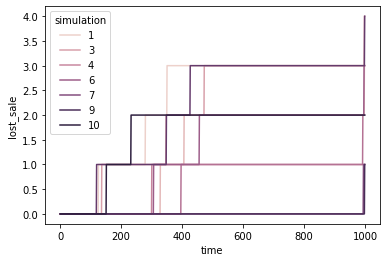

In [21]:
sns.lineplot(data=lost_sale_df, x='time', y='lost_sale', hue='simulation')

<AxesSubplot:xlabel='time', ylabel='inventory_lvl'>

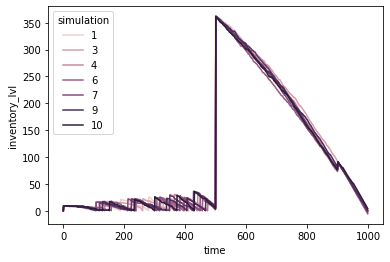

In [22]:
sns.lineplot(data=inventory_lvl_df, x='time', y='inventory_lvl', hue='simulation')

In [23]:
result_df = pd.DataFrame(results, columns =['simulation', 'time', 'state',  'profit', 'optimal_action'])
result_df[result_df['simulation']==1]

,simulation,time,state,profit,optimal_action
0,1,998,0,0.000000,0.0
1,1,997,0,0.000000,0.0
2,1,996,0,0.000000,0.0
3,1,995,0,0.000000,0.0
4,1,994,0,0.000000,0.0
...,...,...,...,...,...
994,1,4,0,3787.362953,9.0
995,1,3,0,3787.302736,9.0
996,1,2,0,3787.232611,9.0
997,1,1,0,3787.152557,9.0


<AxesSubplot:xlabel='time', ylabel='optimal_action'>

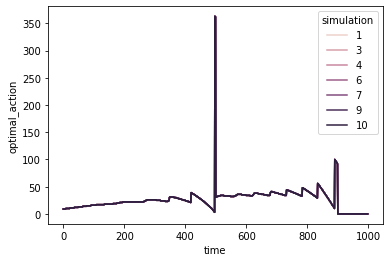

In [24]:
# sns.lineplot(data=result_df, x='time', y='optimal_action', hue='simulation',palette=['#e6194B', '#f58231', '#ffe119', '#bfef45', '#3cb44b', '#42d4f4', '#4363d8', '#911eb4', '#f032e6', '#a9a9a9'])
sns.lineplot(data=result_df, x='time', y='optimal_action', hue='simulation')

In [16]:
values_df = pd.DataFrame(V)
values_df


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,3787.152557,3787.152557,3787.232611,3787.302736,3787.362953,3787.413280,3787.453736,3787.484338,3787.505103,3787.518674,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00
1,3801.006664,3801.016664,3801.020452,3801.017882,3801.008820,3800.993139,3800.970724,3800.941467,3800.905268,3800.862015,...,19.989899,19.989909,19.989919,19.989930,19.989940,19.989950,19.989959,19.98985,19.95002,0.01
2,3812.923375,3812.943375,3812.955310,3812.959192,3812.955031,3812.942830,3812.922589,3812.894306,3812.857975,3812.813588,...,39.969708,39.969738,39.969769,39.969799,39.969829,39.969856,39.969371,39.87002,19.95002,0.02
3,3824.245247,3824.275247,3824.296588,3824.309289,3824.313364,3824.308828,3824.295693,3824.273971,3824.243671,3824.204801,...,59.939436,59.939497,59.939557,59.939618,59.939667,59.938324,59.759980,39.86002,19.95002,0.03
4,3835.216037,3835.256037,3835.287028,3835.309027,3835.322053,3835.326123,3835.321250,3835.307451,3835.284739,3835.253125,...,79.899094,79.899195,79.899296,79.899364,79.896413,79.619880,59.739980,39.85002,19.95002,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,6556.216169,6561.186169,6566.135873,6571.065299,6575.974462,6580.863380,6585.732064,6590.580528,6595.408783,6600.216837,...,139.427780,124.528480,109.619020,94.699420,79.769700,64.829880,49.879980,34.92002,19.95002,4.97
498,6555.407796,6560.387796,6565.347007,6570.285447,6575.203133,6580.100080,6584.976301,6589.831809,6594.666614,6599.480725,...,139.347780,124.458480,109.559020,94.649420,79.729700,64.799880,49.859980,34.91002,19.95002,4.98
499,6554.099451,6559.089451,6564.058162,6569.005603,6573.931789,6578.836735,6583.720456,6588.582963,6593.424266,6598.244376,...,139.267780,124.388480,109.499020,94.599420,79.689700,64.769880,49.839980,34.90002,19.95002,4.99
500,6552.286858,6557.286858,6562.265065,6567.221497,6572.156170,6577.069099,6581.960299,6586.829780,6591.677553,6596.503627,...,139.187780,124.318480,109.439020,94.549420,79.649700,64.739880,49.819980,34.89002,19.95002,5.00


In [17]:
policy_df = pd.DataFrame(alpha)
policy_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
